# Vehicle Detection and Tracking

This is the notebook that I used to develope my Vehicle Detecting and Tracking code for Udacity project 5

In [5]:
# [ Imports ]
# [ -Python ]
import time
import glob
import itertools
# [ -Third Party ]
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage.feature import hog
from sklearn.externals import joblib
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from scipy.ndimage.measurements import label
from moviepy.editor import VideoFileClip
%matplotlib inline

## Convenience Functions

Functions to:

 * Draw a list of boxes on an image
 * To find the center of a box
 * Draw a dot (center of box)
 * Convert colorspaces (BGR to others)
 * Load an image


In [6]:
def draw_boxes(img, bboxes, *, color=(0, 255, 0), thickness=6):
    out_img = np.copy(img)
    for box in bboxes:
        cv2.rectangle(out_img, box[0], box[1], color, thickness)
    return out_img

def box_centroid(bbox):
    x = (((bbox[1][0] - bbox[0][0]) // 2) + bbox[0][0])
    y = (((bbox[1][1] - bbox[0][1]) // 2) + bbox[0][1])
    return (x, y)

def draw_centroids(img, centers, *, color=(255, 0, 0), radius=8):
    out_image = np.copy(img)
    for center in centers:
        cv2.circle(out_image, center, radius=radius, color=color, thickness=-1)
    return out_image

def convert_color_space(image, color_space):
    if color_space == 'RGB':
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    elif color_space == 'HSV':
        image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    elif color_space == 'LUV':
        image = cv2.cvtColor(image, cv2.COLOR_BGR2LUV)
    elif color_space == 'Lab':
        image = cv2.cvtColor(image, cv2.COLOR_BGR2Lab)
    elif color_space == 'HLS':
        image = cv2.cvtColor(image, cv2.COLOR_BGR2HLS)
    elif color_space == 'YUV':
        image = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)
    elif color_space == 'YCrCb':
        image = cv2.cvtColor(image, cv2.COLOR_BGR2YCrCb)
    return image

def load_image(path, *, color_space='RGB'):
    image = cv2.imread(path)
    if image is None:
        raise IOError
    image = convert_color_space(image, color_space)
    return image

def display_images(images, grid, titles):
    pass

### Demo of Drawing functions

Drawing hard-coded boxes on the cars and centroids calculated from that box.

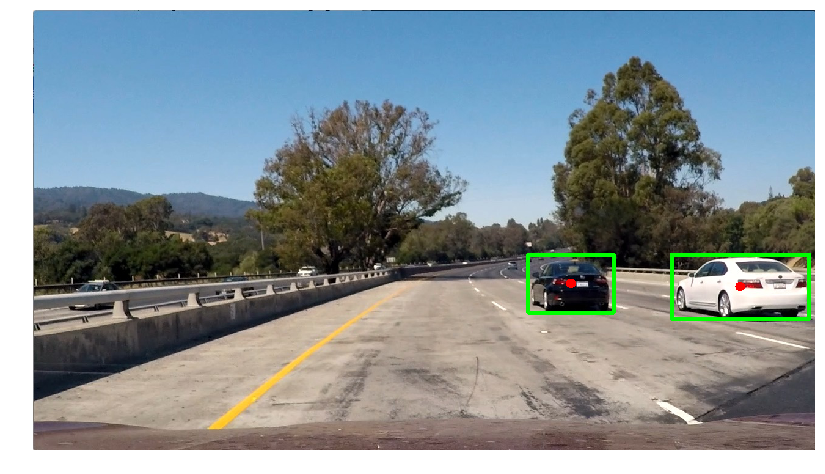

In [40]:
demo_bboxes = [((810, 400), (950, 495)), ((1045, 400), (1270, 505))]
demo_image = load_image('test_images/test1.jpg')
centers = [box_centroid(box) for box in demo_bboxes]
img = draw_boxes(demo_image, bboxes=demo_bboxes)
img = draw_centroids(img, centers)
fig, ax = plt.subplots(1, 1, figsize=(14, 10))
ax.imshow(img)
ax.axis('off')
plt.show()

### Hyperparamers I decided on

In my experience only HOG features worked well enough to reliably find vehicles so I skipped spatial binning and color histogram features to help speed up the pipe line.

In [7]:
color_space = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 0

### Hog feature Extractor.

In [8]:
def get_hog_features(image, visualize=True, feature_vec=True):
    if visualize:
        hog_feat, hog_image = hog(
            image[:, :, hog_channel], 
            orientations=orient, 
            pixels_per_cell=(pix_per_cell,pix_per_cell), 
            cells_per_block=(cell_per_block, cell_per_block), 
            visualise=True, feature_vector=feature_vec)
    else:
        hog_feat = hog(
            image[:, :, hog_channel],
            orientations=orient,
            pixels_per_cell=(pix_per_cell, pix_per_cell),
            cells_per_block=(cell_per_block, cell_per_block),
            visualise=False, feature_vector=feature_vec)
        hog_image = None
    return hog_feat,hog_image

# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Generating bin centers
    bin_edges = channel1_hist[1]
    bin_centers = (bin_edges[1:]  + bin_edges[0:len(bin_edges)-1])/2
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return channel1_hist, channel2_hist, channel3_hist, bin_centers, hist_features
    
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel()
    # Return the feature vector
    return features

def get_features(image):
    hog_feat, _ = get_hog_features(image)
    _, _, _, _, color_feat = color_hist(image, nbins=32, bins_range=(0, 256))
    bin_feat = bin_spatial(image, size=(32, 32))
    feature_vec = np.concatenate((hog_feat, color_feat, bin_feat))
    return feature_vec

### Example of Hog features from the whole image

(509436,)


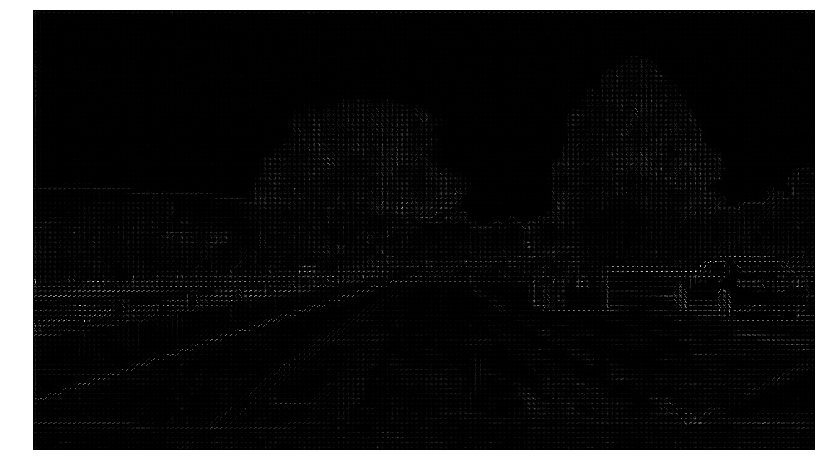

In [7]:
features, image = get_hog_features(demo_image)
print(features.shape)
fig, ax = plt.subplots(1, 1, figsize=(14, 10))
ax.imshow(image, cmap='gray')
ax.axis('off')
plt.show()

## Dataset Creation

Load all data sample image paths and display a sample from both the positive class (Car) and the negative class (not a Car)

8792
8968
(1764,)


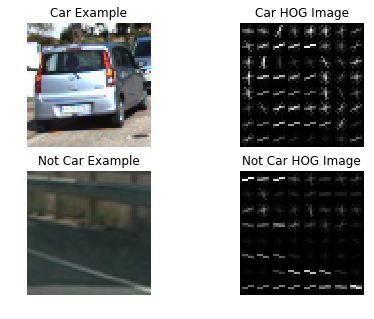

In [70]:
cars = glob.glob('data/vehicles/*/*.png')
notcars = glob.glob('data/non-vehicles/*/*.png')
print(len(cars))
print(len(notcars))

example_idx = np.random.randint(0, min(len(cars), len(notcars)))

demo_car_image = load_image(cars[example_idx])
demo_car_yuv = load_image(cars[example_idx], color_space="YUV")

demo_not_car_image = load_image(notcars[example_idx])
demo_not_car_yuv = load_image(notcars[example_idx], color_space="YUV")

car_features, car_hog_image = get_hog_features(demo_car_yuv)
not_car_features, not_car_hog_image = get_hog_features(demo_not_car_yuv)

test = get_features(demo_car_yuv)

print(car_features.shape)

f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(7, 5))
ax1.imshow(demo_car_image)
ax1.axis('off')
ax1.set_title("Car Example")
ax2.imshow(car_hog_image, cmap='gray')
ax2.axis('off')
ax2.set_title("Car HOG Image")
ax3.imshow(demo_not_car_image)
ax3.axis('off')
ax3.set_title("Not Car Example")
ax4.imshow(not_car_hog_image, cmap='gray')
ax4.axis('off')
ax4.set_title("Not Car HOG Image")
plt.show()

Extract the features from each image

In [71]:
def extract_features(images, *, size=(64, 64)):
    features = []
    for image in images:
        image = load_image(image, color_space="YUV")
        if size != image.shape:
            image = cv2.resize(image, size)
        hog_feat = get_features(image)
        features.append(hog_feat)
    return np.array(features)

In [72]:
car_features = extract_features(cars)
notcar_features = extract_features(notcars)
print(car_features.shape)
print(notcar_features.shape)

(8792, 4932)
(8968, 4932)


Scale features with sklearn

(17760, 4932)


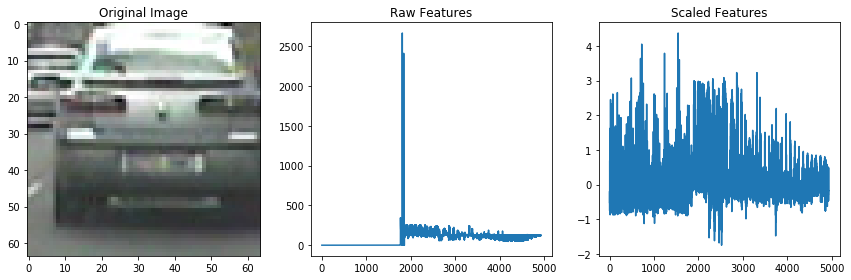

In [73]:
features = np.vstack((car_features, notcar_features)).astype(np.float64)
print(features.shape)
feature_scaler = StandardScaler()
feature_scaler.fit(features)
scaled_features = feature_scaler.transform(features)
example_idx = np.random.randint(0, len(cars))
fig = plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(load_image(cars[example_idx]))
plt.title("Original Image")
plt.subplot(1, 3, 2)
plt.plot(features[example_idx])
plt.title("Raw Features")
plt.subplot(1, 3, 3)
plt.plot(scaled_features[example_idx])
plt.title('Scaled Features')
fig.tight_layout()

Create labels for the features

In [74]:
X = scaled_features
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))
assert X.shape[0] == y.shape[0]

### Train and Test split

Use sklearn to split the data into a train and test set. The random seed is controlled to create reproducable results.

In [75]:
random_seed = 4444
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_seed)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(14208, 4932)
(14208,)
(3552, 4932)
(3552,)


## Classifier Analysis

In [76]:
svm = LinearSVC()
start = time.time()
svm.fit(X_train, y_train)
end = time.time()
print("{:.4f} seconds to train".format(end - start))
print("Train Accuracy of SVM: {}".format(svm.score(X_train, y_train)))
print("Test Accuracy of SVM: {}".format(svm.score(X_test, y_test)))
start = time.time()
prediction = svm.predict(X_test[0].reshape(1, -1))
end = time.time()
print("{:.4f} secondes to predict".format(end - start))
svm_preds = svm.predict(X_test)

13.6822 seconds to train
Train Accuracy of SVM: 1.0
Test Accuracy of SVM: 0.9842342342342343
0.0002 secondes to predict


In [77]:
lr = LogisticRegression(max_iter=10)
start = time.time()
lr.fit(X_train, y_train)
end = time.time()
print("{:.4f} seconds to train".format(end - start))
print("Train Accuracy of LR: {}".format(lr.score(X_train, y_train)))
print("Test Accuracy of LR: {}".format(lr.score(X_test, y_test)))
start = time.time()
prediction = lr.predict(X_test[0].reshape(1, -1))
end = time.time()
print("{:.4f} secondes to predict".format(end - start))

25.4988 seconds to train
Train Accuracy of LR: 1.0
Test Accuracy of LR: 0.9870495495495496
0.0002 secondes to predict


In [78]:
mlp = MLPClassifier(random_state=999)
start = time.time()
mlp.fit(X_train, y_train)
end = time.time()
print("{:.4f} seconds to train".format(end - start))
print("Train Accuracy of LR: {}".format(mlp.score(X_train, y_train)))
print("Test Accuracy of LR: {}".format(mlp.score(X_test, y_test)))
start = time.time()
prediction = mlp.predict(X_test[0].reshape(1, -1))
end = time.time()
print("{:.4f} secondes to predict".format(end - start))

34.8596 seconds to train
Train Accuracy of LR: 1.0
Test Accuracy of LR: 0.9938063063063063
0.0007 secondes to predict


In [79]:
def plot_confusion_matrix(y_true, y_pred, classes, *, labels=None):
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.title("Confusion Matrix")
    plt.colorbar()
    plt.ylabel('True Labels')
    plt.xlabel('Predicted Labels')
    thresh = cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(
            j, i, cm[i, j], 
            horizontalalignment='center', 
            color='white' if cm[i, j] > thresh else "black"
        )

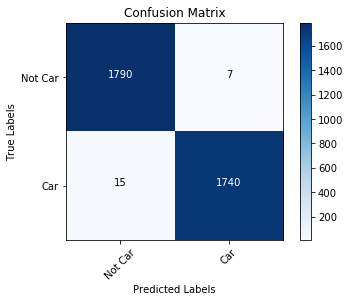

In [80]:
test_preds = mlp.predict(X_test)
plot_confusion_matrix(y_test, test_preds, ["Not Car", "Car"])

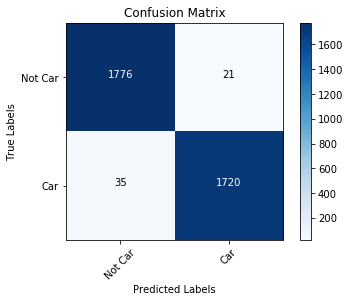

In [81]:
plot_confusion_matrix(y_test, svm_preds, ["Not Car", "Car"])

#### Decisions
The Logistic regression and the SVM are so close they are almost interchangeable (which makes since, a LinearSVM is basically Logistic regression with a different loss function). The MLP was slightly slower but had better accuracy, which again makes sense due to the non-linearity/deepness (compared to a linear classifier) of it.

The main reason to choose it is looking at it's confusion matrix it had far fewer instances of False positives and false negativse than the SVM and when the thing that relies on this classifier is a car being correct is very important. 

In [82]:
joblib.dump(mlp, 'mlp.pkl')
joblib.dump(feature_scaler, 'scaler.pkl')

['scaler.pkl']

In [9]:
mlp = joblib.load('mlp.pkl')
feature_scaler = joblib.load('scaler.pkl')

In [10]:
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

Function to create the sliding windows at various scales and shows what a few of those windowslook like on the image.

2662


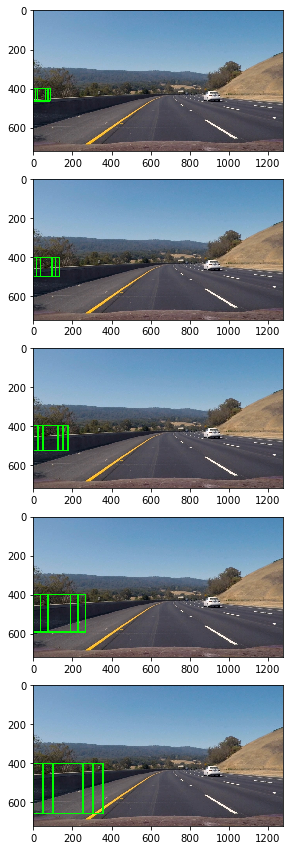

In [16]:
demo_image = load_image('test_images/test3.jpg')
def create_windows(demo_image, vis=False):
    sizes = [64, 96, 128, 192, 256]
    windows = []
    images = []
    for size in sizes:
        boxes = slide_window(demo_image,
            y_start_stop=[400, 660], 
            xy_window=(size, size), 
            xy_overlap=(0.8, 0.8)
        )
        if vis:
            images.append(draw_boxes(np.copy(demo_image), boxes[:3]))
        windows.extend(boxes)
    return windows, images
    
windows, images = create_windows(demo_image, vis=True)
print(len(windows))
f, ax = plt.subplots(len(images), 1, figsize=(30, 15))
for i, image in enumerate(images):
    ax[i].imshow(image)
plt.show()

#### The whole HOG.

This was code I used to try to get the hog features from the whole image and then sub sample windows from that rahter than cutting out a window and getting features from that. This approach lead to a huge amount of false positives and the heat map threshold was so large that most of a car was removed. This forced me to abandoned this approach.

In [ ]:
import time
start = time.time()
out_images = []
out_maps = []
out_titles = []
out_boxes = []
img_boxes = []
ystart = 400
ystop = 656
scales = [1, 1.5, 2, 2.5, 3]
images = glob.glob('test_images/*.jpg')
for image_path in images:
    image = load_image(image_path, color_space='YUV')
    draw_image = load_image(image_path, color_space='RGB')
    heatmap = np.zeros_like(draw_image[:,:,0])
    for scale in scales:
        image_to_search = image[ystart:ystop]
        if scale != 1:
            imshape = image_to_search.shape
            image_to_seach = cv2.resize(image_to_search, (np.int(imshape[1]/scale), np.int(imshape[0]/2)))
        nxblocks = (image_to_search.shape[1] // pix_per_cell) - 1
        nyblocks = (image_to_search.shape[0] // pix_per_cell) - 1
        nfeat_per_block = orient*cell_per_block**2
        window = 64
        nblocks_per_window = (window // pix_per_cell) - 1
        cells_per_step = 4
        nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
        nysteps = (nyblocks - nblocks_per_window) // cells_per_step
        feats = raw_hog(image_to_search)
        count = 0
        for xb in range(nxsteps):
            for yb in range(nysteps):
                count += 1
                ypos = yb * cells_per_step
                xpos = xb * cells_per_step
                xleft = xpos * pix_per_cell
                ytop = ypos * pix_per_cell
                feat = feats[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
                scaled_feats = feature_scaler.transform(feat)
                pred = mlp.predict(scaled_feats)
                if pred == 1:
                    xbox_left = np.int(xleft*scale)
                    ytop_draw = np.int(ytop*scale)
                    win_draw = np.int(window*scale)
                    cv2.rectangle(draw_image, (xbox_left, ytop_draw+ystart), (xbox_left+win_draw, ytop_draw+win_draw+ystart), (0,0,255), 6)
                    img_boxes.append(((xbox_left, ytop_draw+ystart), (xbox_left+win_draw, ytop_draw+win_draw+ystart)))
                    heatmap[ytop_draw+ystart:ytop_draw+ystart+win_draw, xbox_left:xbox_left+win_draw] += 1
        
    heatmap[heatmap <= 2] = 0
    heatmap = np.clip(heatmap, 0, 255)
    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.imshow(draw_image)
    ax2.imshow(heatmap)

Functions to add detections to the the heatmap. This is used to remove false positives.

In [17]:
def add_heat(heat_map, bboxes):
    for box in bboxes:
        heat_map[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
    return heat_map

def threshold_heat_map(heat_map, threshold):
    heat_map[heat_map <= threshold] = 0
    return heat_map

def label_bboxes(labels):
    bboxes = []
    for car_number in range(1, labels[1] + 1):
        nonzero = (labels[0] == car_number).nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        bboxes.append(bbox)
    return bboxes

Function to find cars in an image with high accuracy. There is also a parallel implementation. There is also a plotting function to show the steps to detect cars.

In [18]:
def detect_cars(image, windows, clf, scale, size=(64, 64)):
    detected = []
    for window in windows:
        current = cv2.resize((image[window[0][1]: window[1][1], window[0][0]: window[1][0]]), size)
        features = get_features(current)
        scaled_features = scale.transform(features)
        if current.shape[0] > 0:
            if mlp.predict_proba(scaled_features.reshape(1, -1))[0][1] > .98:
                detected.append(window)
    return detected

from multiprocessing import Process, Queue, cpu_count
from math import ceil
                
def car_detect_worker(image, windows, clf, scale, q):
    heat_map = np.zeros_like(image[:, :, 0])
    detected = detect_cars(image, windows, clf, scale)
    heat_map = add_heat(heat_map, detected)
    q.put(heat_map)

def parallel_annotate(image, show=False):
    raw_image = load_image(image)
    out_image = np.copy(raw_image)
    image = load_image(image, color_space="YUV")
    windows, _ = create_windows(image)
    num_workers = cpu_count()
    windows_per_worker = ceil(len(windows) / num_workers)
    q = Queue()
    for i in range(num_workers):
        worker = Process(target=car_detect_worker, args=(image, windows[i*windows_per_worker:(i+1)*windows_per_worker], mlp, feature_scaler, q))
        worker.daemon = True
        worker.start()
    heat_maps = []
    for i in range(num_workers):
        heat_maps.append(q.get())
    
    heat_map = np.sum(np.array(heat_maps), axis=0)
    heat_map = threshold_heat_map(heat_map, 2)
    heat_map = np.clip(heat_map, 0, 255)
    labels = label(heat_map)
    boxes = label_bboxes(labels)
    out_image = draw_boxes(out_image, boxes)
    
    if show:
        f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(15, 9))
        f.tight_layout()
        ax1.axis('off')
        ax1.set_title('Image')
        ax1.imshow(raw_image)
        ax2.axis('off')
        ax2.set_title('Heat Map')
        ax2.imshow(heat_map, cmap='hot')
        ax3.axis('off')
        ax3.set_title('Labels')
        ax3.imshow(labels[0], cmap='gray')
        ax4.axis('off')
        ax4.set_title('Annotated Image')
        ax4.imshow(out_image)
    
    return out_image
    
def annotate_image(image, show=False):
    raw_image = load_image(image)
    image = load_image(image, color_space="YUV")
    windows, _ = create_windows(image)
    detected = detect_cars(image, windows, mlp, feature_scaler)
    out_image = np.copy(raw_image)
    heat_map = np.zeros_like(image[:,:,0])
    heat_map = add_heat(heat_map, detected)
    
    heat_map = threshold_heat_map(heat_map, 2)
    heat_map = np.clip(heat_map, 0, 255)
    labels = label(heat_map)
    boxes = label_bboxes(labels)
    out_image = draw_boxes(out_image, boxes)
    
    if show:
        f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(15, 9))
        f.tight_layout()
        ax1.axis('off')
        ax1.set_title('Image')
        ax1.imshow(raw_image)
        ax2.axis('off')
        ax2.set_title('Heat Map')
        ax2.imshow(heat_map, cmap='hot')
        ax3.axis('off')
        ax3.set_title('Labels')
        ax3.imshow(labels[0], cmap='gray')
        ax4.axis('off')
        ax4.set_title('Annotated Image')
        ax4.imshow(out_image)
    return out_image

222.2858579158783


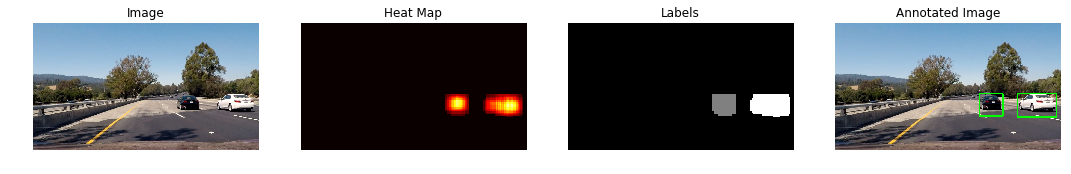

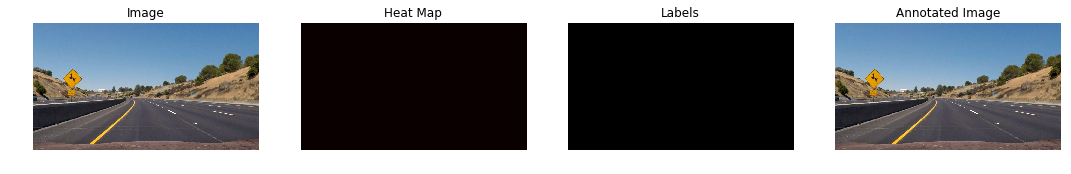

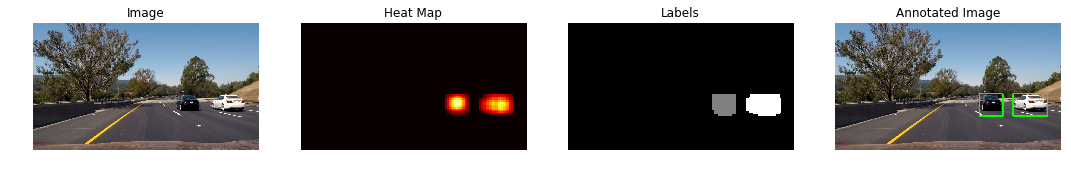

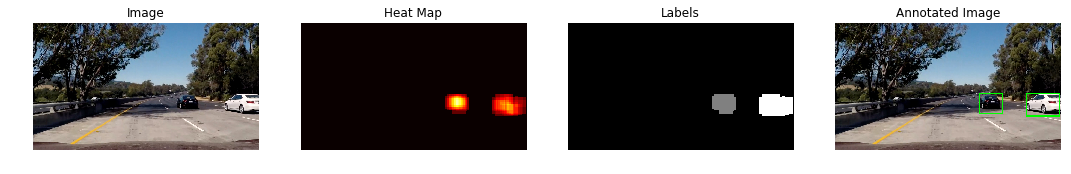

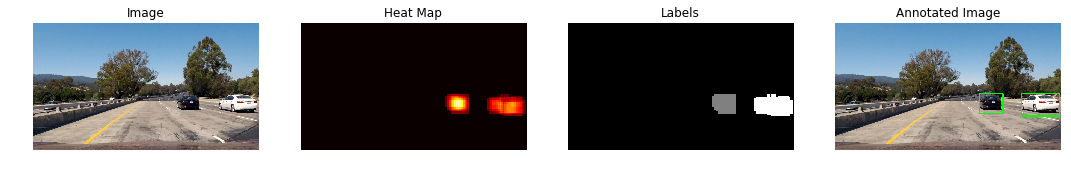

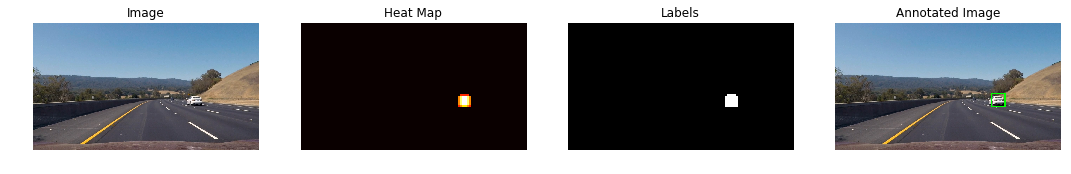

In [19]:
import time
start = time.time()
for image in glob.glob('test_images/*.jpg'):
    parallel_annotate(image, show=True)
print(time.time() - start)

247.21710872650146


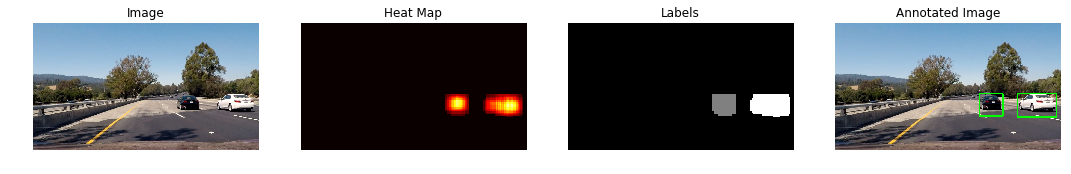

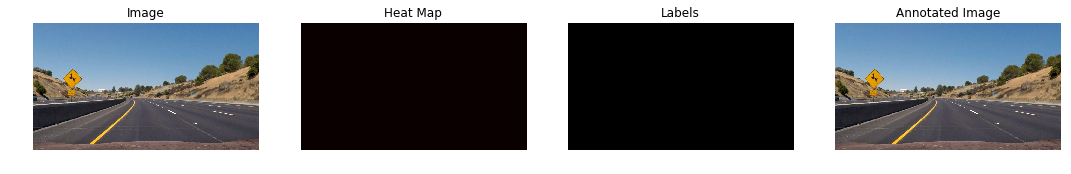

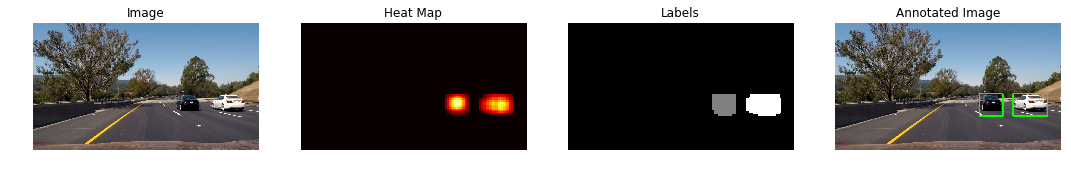

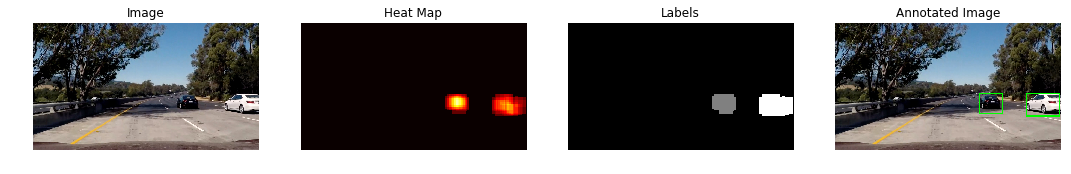

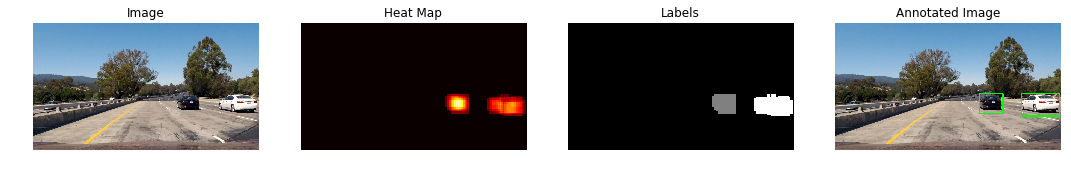

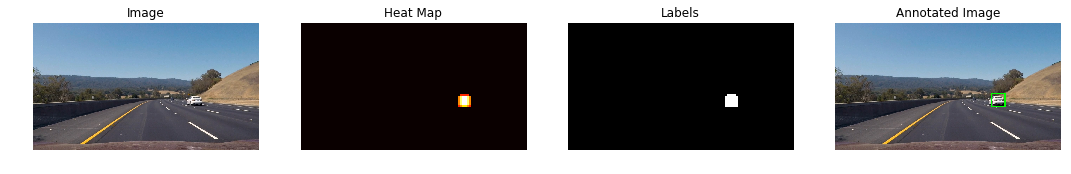

In [20]:
start = time.time()
for image in glob.glob('test_images/*.jpg'):
    annotate_image(image, show=True)
print(time.time() - start)

Temporal processing. A deque is used to hold past detection boxes. When new boxes (one for each car due to the heatmap and labels) are found the are added to the queue and the old boxes are pushed off the back. 

In [22]:
from collections import deque
class boxes:
    def __init__(self):
        self.count = 0
        self.detections = deque(maxlen=12)

open CV's group rectanges is used to smooth recatangles overtime. False positives won't any overlapping rectangles and therefore won't be shown. 

In [23]:
def process_vid(image):
    result = np.copy(image).astype('uint8')
    image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
    windows, _ = create_windows(image)
    detected = detect_cars(image, windows, mlp, feature_scaler)
    
    heat_map = np.zeros_like(image[:,:,0])
    heat_map = add_heat(heat_map, detected)
    heat_map = threshold_heat_map(heat_map, 2)
    heat_map = np.clip(heat_map, 0, 255)
    labels = label(heat_map)
    boxes = label_bboxes(labels)
    #result = draw_boxes(result, boxes)
    
    Boxes.detections.append(boxes)
    all_boxes = []
    combined = np.ravel(np.array(Boxes.detections))
    for i in range(len(combined)):
        all_boxes.extend(np.ravel(combined[i]))
    new_boxes = []
    i = 0
    while i <= len(all_boxes)-3:
        new_boxes.append(all_boxes[i:i+4])
        new_boxes.append(all_boxes[i:i+4])
        i += 4
    rects,w = cv2.groupRectangles(np.array(new_boxes).tolist(), 10,.1)
    for rect in rects:
        cv2.rectangle(result, (rect[0], rect[1]), (rect[2],rect[3]), (255,0,0), 5)
    Boxes.count += 1
    return result

In [24]:
Boxes = boxes()
output = 'result.mp4'
clip1 = VideoFileClip('project_video.mp4').subclip(5,) # The first 5 seconds doesn't have any cars...
clip = clip1.fl_image(process_vid)
%time clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video result.mp4
[MoviePy] Writing video result.mp4


100%|█████████▉| 1135/1136 [10:56:56<00:33, 33.58s/it] 


[MoviePy] Done.
[MoviePy] >>>> Video ready: result.mp4 

CPU times: user 16h 1min 28s, sys: 1d 1h 35min 42s, total: 1d 17h 37min 10s
Wall time: 10h 56min 58s
